by Gerard Caravaca and Nicolás Álvarez

## **Semantic Textual Similarity**

# **Introduction**

Semantic Similarity, or Semantic Textual Similarity, is a task in the area of Natural Language Processing (NLP) that scores the relationship between texts or documents using a defined metric. For this project, a participation in SemEval 2012 will be simulated. SemEval (Semantic Evaluation Exercises) is a series of workshops whose main objective is the evaluation and comparison of semantic analysis systems. 

The purpose is to recognise similarity of phrases in different fields. To do this, the following steps will be followed:



1.   Set up
2.   Data loading
3.   Feature extraction
4.   Feature selection
5.   ML model development
6.   Results evaluation

# **1. Set up**

In this section all the functions necessary for the project are imported. Furthermore, the notebook is placed in the working environment.

In [ ]:
#import from packages
import pandas as pd
import numpy as np
import sys
from google.colab import drive
from sklearn.feature_selection import r_regression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
#connect to GD work directory
drive.mount('/content/drive')
PATH='/content/drive/MyDrive/Colab Notebooks/IHLT/STS'
SOURCE_PATH=PATH+'/utils'
sys.path.append(SOURCE_PATH)

Mounted at /content/drive


In [ ]:
#import from our code
from evaluation import *
from data import *
from similarities import  *
from features import *

[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


#**2. Data loading**

In this section, the train and test sentences are loaded. This data is provided by SemEval and consists of test, training and trial data sets. These will be the only data that can be used in this exercise. This data contains various data sets with phrases extracted from different fields:

*   MSRpar: Microsoft Research Paraphrase Corpus. 
    http://research.microsoft.com/en-us/downloads/607d14d9-20cd-47e3-85bc-a2f65cd28042/
  750 pairs of sentences for train and test.
*   MSRvid: Microsoft Research Video Description Corpus. http://research.microsoft.com/en-us/downloads/38cf15fd-b8df-477e-a4e4-a4680caa75af/
  750 pairs of sentences for train and test.
*   SMTeuropar: WMT2008 develoment dataset (Europarl section). http://www.statmt.org/wmt08/shared-evaluation-task.html
  734 pairs of sentences for train and test.
*  2 surprise data sets for test.

In [ ]:
#load input sentences
train_data, test_data, train_labels, test_labels=load_data(PATH)
print('#Train sentences: ', len(train_data))
print('#Test sentences: ', len(test_data))

#Train sentences:  2234
#Test sentences:  3108


# **3. Feature extraction**

The next step to follow if we want to solve this problem with a machine learning model is feature extraction. This refers to the process of selecting and transforming the input data into a format that is suitable for the machine learning model being used. This includes selecting relevant features in the input data, removing irrelevant or redundant features, and transforming or combining features into a format that is suitable for the model. For this we have used the information provided in some of the papers presented to the royal competition [1] [2] [3]. 

The features chosen to analyse in this exercise are as follows:

*   **Lemmas**: extraction of each of the lemmas of a sentence.
*   **Lemmas and stop-words**: in addition to including the lemmas of a sentence in the comparison, stop-words are also added.
*   **Named Entities**: extract named entities of a sentence. 
*   **Dependency parser**: extract structure of Spacy dependency parser.
*   **Noun phrases**: extract noun phrases of a sentence.
*   **Verb phrases**: extract verb phrases of a sentence.
*   **Lesk**: apply lesk algorithm to the sentence to solve the problem of disambiguation of words in a given context. 
*   **Stems**: Stemmatisation is a process in which a word is reduced to its root, also known as stem. This involves removing the endings of a word to leave its basic root. 
*   **Bigrams**: comparison of sequences of two words in each sentence.
*   **Trigrams**: comparison of sequences of three words in each sentence.
*   **Path similarity**: apply the path similarity metric as a semantic similarity between words.
*   **Leacock-Chodorow similarity**: apply the Leacock-Chodorow similarity metric as a semantic similarity between words.
*   **Wu-Palmer similarity**: apply the Wu-Palmer similarity metric as a semantic similarity between words.
*   **Lin similarity**: apply the Lin similarity metric as a semantic similarity between words.

Finally, the metrics used to calculate similarity between sentences taking into account each of the techniques described are as follows:

*   **Jaccard similarity**
*   **Dice similarity**
*   **Cosine similarity**








In [ ]:
#functions for extracting all features efficiently
def get_features_similarity(dataset, spacy_features, other_features, similarities, lexical_semantics):
  final_set=[]
  index=0
  for sentence1, sentence2 in dataset: #iterate pair of sentences
    if index%100 == 0:
      print('   -> sentences: ' + str(index) + '/' + str(len(dataset)))
    sims=[]
    doc1=nlp(sentence1)
    doc2=nlp(sentence2)
    tok1=tokenize(sentence1)
    tok2=tokenize(sentence2)
    for f in spacy_features:
      for similarity in similarities:
        s1 = f(doc1)
        s2 = f(doc2)
        if len(s1) == 0 and len(s2)==0:
          sims.append(0)
        else:
          sims.append(similarity(set(s1),set(s2)))
    for f in other_features:
      for similarity in similarities:
        s1 = f(tok1)
        s2 = f(tok2)
        if len(s1) == 0 and len(s2)==0:
          sims.append(0)
        else:
          sims.append(similarity(set(s1),set(s2)))
    lex=get_lexical_similarities(doc1, doc2, lexical_semantics)
    for l in lex:
      sims.append(l)
    final_set.append(sims)
    index+=1
  return final_set
  
def extract_features(dataset, wanted_features):
  spacy_features=[]
  others_features=[]
  lexical_semantics=[]

  #using spacy (split for efficiency)
  if 'lemmas' in wanted_features:
    spacy_features.append(lemmatize)
  if 'NEs' in wanted_features:
    spacy_features.append(lemmatize_and_NEs)
  if 'dependency_parse' in wanted_features:
    spacy_features.append(dependency_parser)
  if 'lemmas_sw' in wanted_features:
    spacy_features.append(lemmatize_and_sw)
  if 'NP' in wanted_features:
    spacy_features.append(noun_phrase)
  if 'VP' in wanted_features:
    spacy_features.append(verb_phrase)
  
  #lexical semantics
  if 'path_similarity' in wanted_features:
    lexical_semantics.append(path_similarity)
  if 'wup_similarity' in wanted_features:
    lexical_semantics.append(wup_similarity)
  if 'lch_similarity' in wanted_features:
    lexical_semantics.append(lch_similarity)
  if 'lin_similarity' in wanted_features:
    lexical_semantics.append(lin_similarity)

    #others
  if 'lesk' in wanted_features:
    others_features.append(lesk_word_sense)
  if 'stems' in wanted_features:
    others_features.append(stemmatize)
  if 'bigrams' in wanted_features:
    others_features.append(bigrams)
  if 'trigrams' in wanted_features:
    others_features.append(trigrams)

  results=get_features_similarity(dataset, spacy_features,  others_features, [jaccard, dice_similarity, cosine_similarity], lexical_semantics)
  return results

In [ ]:
list_f=['lemmas', 'NEs', 'dependency_parse','lemmas_sw', 'NP', 'VP', 'lesk', 'stems', 'bigrams', 'trigrams', 'path_similarity', 'wup_similarity', 'lch_similarity', 'lin_similarity']
print('computing features for train dataset...')
train_features=extract_features(train_data, list_f)
print('computing features for test dataset...')
test_features=extract_features(test_data, list_f)
print('#features: ', len(train_features[0]))

computing features for train dataset...
   -> sentences: 0/2234
   -> sentences: 100/2234
   -> sentences: 200/2234
   -> sentences: 300/2234
   -> sentences: 400/2234
   -> sentences: 500/2234
   -> sentences: 600/2234
   -> sentences: 700/2234
   -> sentences: 800/2234
   -> sentences: 900/2234
   -> sentences: 1000/2234
   -> sentences: 1100/2234
   -> sentences: 1200/2234
   -> sentences: 1300/2234
   -> sentences: 1400/2234
   -> sentences: 1500/2234
   -> sentences: 1600/2234
   -> sentences: 1700/2234
   -> sentences: 1800/2234
   -> sentences: 1900/2234
   -> sentences: 2000/2234
   -> sentences: 2100/2234
   -> sentences: 2200/2234
computing features for test dataset...
   -> sentences: 0/3108
   -> sentences: 100/3108
   -> sentences: 200/3108
   -> sentences: 300/3108
   -> sentences: 400/3108
   -> sentences: 500/3108
   -> sentences: 600/3108
   -> sentences: 700/3108
   -> sentences: 800/3108
   -> sentences: 900/3108
   -> sentences: 1000/3108
   -> sentences: 1100/3108


The features of the input data are now transformed into a common scale. **Scaling** the features allows all features to have the same weight in the distance calculation, which can improve the accuracy and performance of the machine learning model.



In [ ]:
standard_scaler = StandardScaler()
standard_scaler.fit(train_features)
scaled_features_train = standard_scaler.transform(train_features)
scaled_features_test = standard_scaler.transform(test_features)

# **4. Feature selection**

With this we have extracted 34 features which may be too many in this case.  Also, analysing these, some of them will have little impact on the final model. For this reason we need a selection of the best ones. Feature selection is important because model performance can be improved by using only relevant features instead of all available features. In addition, using only relevant features can reduce training time and improve model interpretability. 

To decide which features to keep we extract the correlation between each of them and the gold standard in the train sentences.

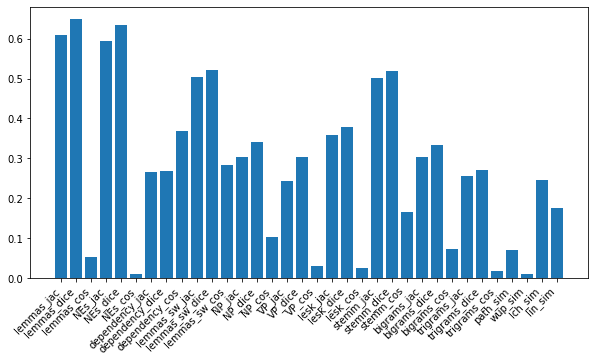

In [ ]:
feature_correlation=r_regression(scaled_features_train, train_labels)
feature_names = ['lemmas_jac', 'lemmas_dice', 'lemmas_cos', 'NEs_jac', 'NEs_dice', 'NEs_cos', 'dependency_jac', 'dependency_dice', 'dependency_cos', 'lemmas_sw_jac', 'lemmas_sw_dice', 'lemmas_sw_cos', 'NP_jac', 'NP_dice', 'NP_cos', 'VP_jac', 'VP_dice', 'VP_cos', 'lesk_jac', 'lesk_dice', 'lesk_cos', 'stemm_jac', 'stemm_dice', 'stemm_cos', 'bigrams_jac', 'bigrams_dice', 'bigrams_cos', 'trigrams_jac', 'trigrams_dice', 'trigrams_cos', 'path_sim', 'wup_sim', 'lch_sim', 'lin_sim']
dic = {feature_names[i]: feature_correlation[i] for i in range(len(feature_names))}
fig = plt.figure(figsize = (10, 5))
plt.bar(dic.keys(), np.abs(list(dic.values())))
plt.xticks(rotation=45, ha="right")
plt.show()

As can be seen in the plot there are some features that have very little impact. In order to proceed, we decided to keep the features that have a correlation > 0.25.

In [ ]:
values=np.abs(list(dic.values()))
sel_ids = [n for n,i in enumerate(values) if i>0.25]

scaled_features_train = scaled_features_train[:,sel_ids]
scaled_features_test = scaled_features_test[:,sel_ids]

print('Best features: ', [i for n,i in enumerate(feature_names) if n in sel_ids])

Best features:  ['lemmas_jac', 'lemmas_dice', 'NEs_jac', 'NEs_dice', 'dependency_jac', 'dependency_dice', 'dependency_cos', 'lemmas_sw_jac', 'lemmas_sw_dice', 'lemmas_sw_cos', 'NP_jac', 'NP_dice', 'VP_dice', 'lesk_jac', 'lesk_dice', 'stemm_jac', 'stemm_dice', 'bigrams_jac', 'bigrams_dice', 'trigrams_jac', 'trigrams_dice']


# **5. ML model selection**

Several models were tested, among them were tested: Random Forest, Support Vector Machines and Multi-layer Perceptrons. However, the process that yielded the best results was the following:

1.  We first trained 4 regression models with Support vector machines, the first three with each of the train data sets and the last one with all of them.

In [ ]:
#function for training a model
def train_SVR_model(train_data, test_data, train_labels, test_labels):
  data = np.concatenate([train_data, test_data])
  labels = np.concatenate([train_labels, test_labels])
  fold = np.array([-1]*train_data.shape[0] + [0]*train_data.shape[0])
  fold_split = PredefinedSplit(fold)

  pearson_scorer = make_scorer(lambda y, y_hat: pearsonr(y, y_hat)[0])

  gamma = np.logspace(-3, -1, 3)
  C = np.array([0.1, 0.5, 1, 2, 10, 15, 20, 50, 100, 250, 500])
  e = np.linspace(0.1, 1, 10)
  parameters = dict(gamma=gamma, C=C, epsilon=e)

  svr = SVR(kernel='rbf', tol=1)
  cv = GridSearchCV(svr,
                      parameters,
                      cv=fold_split,
                      scoring=pearson_scorer,
                      n_jobs=-1,
                      verbose=1)
  print('searching best parameters...')
  cv = cv.fit(data, labels)

  best_params = cv.best_params_
  print(best_params)
  model = SVR(kernel='rbf', tol=1, **best_params)
  print('training model...')
  model.fit(train_data, train_labels)
  print('SVR trained succesfully.')

  return model

In [ ]:
#MSRpar model
model_MSRpar=train_SVR_model(scaled_features_train[0:750], scaled_features_test[0:750], train_labels[0:750], test_labels[0:750])
#MSRvid model
model_MSRvid=train_SVR_model(scaled_features_train[750:1500], scaled_features_test[750:1500], train_labels[750:1500], test_labels[750:1500])
#Europarl model
model_euro=train_SVR_model(scaled_features_train[1500:1959], scaled_features_test[1500:1959], train_labels[1500:1959], test_labels[1500:1959])
#complete model
model=train_SVR_model(scaled_features_train, scaled_features_test, train_labels, test_labels)

searching best parameters...
Fitting 1 folds for each of 330 candidates, totalling 330 fits
{'C': 2.0, 'epsilon': 0.2, 'gamma': 0.01}
training model...
SVR trained succesfully.
searching best parameters...
Fitting 1 folds for each of 330 candidates, totalling 330 fits
{'C': 15.0, 'epsilon': 0.5, 'gamma': 0.01}
training model...
SVR trained succesfully.
searching best parameters...
Fitting 1 folds for each of 330 candidates, totalling 330 fits
{'C': 0.5, 'epsilon': 0.2, 'gamma': 0.1}
training model...
SVR trained succesfully.
searching best parameters...
Fitting 1 folds for each of 330 candidates, totalling 330 fits
{'C': 1.0, 'epsilon': 0.2, 'gamma': 0.1}
training model...
SVR trained succesfully.


Each test is then predicted with its corresponding model. In the case of the pop quizzes, the full model is used.

In [ ]:
predicted_MSRpar=model_MSRpar.predict(scaled_features_test[0:750])
predicted_MSRvid=model_MSRvid.predict(scaled_features_test[750:1500])
predicted_euro=model_euro.predict(scaled_features_test[1500:1959])
predicted_surpirse=model.predict(scaled_features_test[1959:])

Finally, the predictions are concatenated in order to follow the indicated format and to be able to evaluate results correctly.

In [ ]:
prediction=np.concatenate((predicted_MSRpar, predicted_MSRvid, predicted_euro, predicted_surpirse))

*  It should be clarified that the kernel chosen in this case is the radial basis function. The RBF kernel is a function that is defined as the product of a Gaussian function and a radial basis function, and is used to map the input data into an infinite dimensional feature space where it is possible to find a linear separation between data classes. The reason for this decision is that this kernel has a proven ability to handle non-linearly separable data.

# **6. Results Evaluation**

The correctness of the results is assessed using the pearson correlation with the gold standard provided.


In [ ]:
test_pearson=compute_pearson(prediction, test_labels)
print('pc test: ', test_pearson)

pc test:  0.7812836983345902


A pearson correlation of 0.78128 has been obtained using this approach. This is a very good result given that it is among the top 10 participants in the SemEval competition. 

# **Conclusion**

In conclusion, we presented a proposal for a solution to the STS project that performs quite well. The proposal was based on an SVR algorithm applied over some lexical and semantical similarity metrics, with a feature selection step and training four models, each specialising in a particular field of study, that improved the model further, yielding a final correlation score of 0.78128. Our process's drawback is that it has a higher cost in memory and execution time. This occurs because we use four models instead of just one, which increases the cost.

Another consequence of the procedure we are aware of is the overfitting of using four different models, each one for each workshop in the dataset. However, we chose to proceed this way for this work's sake because, although the models are biased with the training data and cannot be generalised to other datasets, their performance on these particular test data is remarkable.

# **References**

[1] Daniel Bar, Chris Biemann , Iryna Gurevych, Torsten Zesch (. UKP: Computing Semantic Textual Similarity by
Combining Multiple Content Similarity Measures. Department of Computer Science, Technische Universitat Darmstadt. https://gebakx.github.io/ihlt/sts/docs/1-ukp.pdf .


[2] Frane Saric, Goran Glavas, Mladen Karan,Jan Snajder, and Bojana Dalbelo Basic. TakeLab: Systems for Measuring Semantic Text Similarity. University of Zagreb. https://gebakx.github.io/ihlt/sts/docs/2-takelab.pdf .

[3] Michael Heilman, Nitin Madnani. ETS: Discriminative Edit Models for Paraphrase Scoring. Educational Testing Service. Princeton, NJ 08541, USA. https://gebakx.github.io/ihlt/sts/docs/6-ets.pdf .